<h1><center>Reviews Sentiment Analysis</center></h1>
<h3><center>Sentiment Analysis of the reviews on Olist</center></h3>

Reviews and ratings are given to the products sold on the Olist website. These reviews can be used to understand the sentiment of the review towards a product. These sentiments can help recognize popular products on the Olist website.

There are two approaches to this problem. Supervised sentiment analysis can be performed using ratings given as the target. Unsupervised learning can be performed to estimate the sentiments of these reviews and hence the popularity of a product. For unsupervised, the reviews have to be translated to English.<br>

The notebook, will deal with both these methods.

In [184]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from googletrans import Translator
from afinn import Afinn
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
import re
import time

STOP_WORDS= stopwords.words('portuguese')
STOP_WORDS_ENG = stopwords.words('english')

In [153]:
df= pd.read_csv('/home/raj/Github/Olist-business-analysis/Joined data/porduct_review.csv', index_col=0)
# df['review_eng'] = ""
df.head(5)

/home/raj/anaconda3/envs/r_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,review_eng
0,d71da8fd8c6e3adef26be965f065b8a1,e17e4f88e31525f7deef66779844ddce,5,Vale a pena,Super adooorei o delineador ele é bem preto e ...,2018-04-28 00:00:00,2018-05-04 00:55:02,1e9e8ef04dbcff4541ed26657ea517e5,Super adooorei eyeliner it's very black and I ...
1,19866247db89845ef558ef19a6c26fcd,5236307716393b7114b53ee991f36956,5,NaN,Excelente apontador! Em 3 segundos uma ponta p...,2018-02-17 00:00:00,2018-02-18 23:24:14,3aa071139cb16b67ca9e5dea641aaa2f,Excellent pointing! In 3/2 a perfect tip!
2,32921b4e09c9a19d61fe46ce04231b84,01f66e58769f84129811d43eefd187fb,5,NaN,NaN,2018-07-14 00:00:00,2018-07-16 16:20:04,96bd76ec8810374ed1b65e291975717f,NaN
3,70949d129965fb1ee32aaccec720a19e,143d00a4f2dde4e0364ee1821577adb3,1,produto divergente,modelo comprado: travesseiro memoria carinho B...,2018-08-07 00:00:00,2018-08-08 11:53:04,cef67bcfe19066a932b7673e239eb23d,model purchased: pillow memory affection BABY ...
4,74c9c7d0bc153bbbc92e4c1597b8ba55,86cafb8794cb99a9b1b77fc8e48fbbbb,5,NaN,NaN,2018-04-17 00:00:00,2018-04-18 04:29:47,9dc1a7de274444849c219cff195d0b71,NaN


The imported dataset - product_review has a mapping of product_id to the review and rating recieved from each order. For the translation, the emojis from the text have been removed since they are not supported by the Google translator.

The function below removes the following from each review if exists. 
* emojis
* symbols, pictographs
* flags
* map symbols


In [17]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df.review_comment_message = df.review_comment_message.apply(lambda text: remove_emoji(str(text)))
df.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,review_eng
0,d71da8fd8c6e3adef26be965f065b8a1,e17e4f88e31525f7deef66779844ddce,5,Vale a pena,Super adooorei o delineador ele é bem preto e ...,2018-04-28 00:00:00,2018-05-04 00:55:02,1e9e8ef04dbcff4541ed26657ea517e5,Super adooorei eyeliner it's very black and I ...
1,19866247db89845ef558ef19a6c26fcd,5236307716393b7114b53ee991f36956,5,NaN,Excelente apontador! Em 3 segundos uma ponta p...,2018-02-17 00:00:00,2018-02-18 23:24:14,3aa071139cb16b67ca9e5dea641aaa2f,Excellent pointing! In 3/2 a perfect tip!
2,32921b4e09c9a19d61fe46ce04231b84,01f66e58769f84129811d43eefd187fb,5,NaN,nan,2018-07-14 00:00:00,2018-07-16 16:20:04,96bd76ec8810374ed1b65e291975717f,NaN
3,70949d129965fb1ee32aaccec720a19e,143d00a4f2dde4e0364ee1821577adb3,1,produto divergente,modelo comprado: travesseiro memoria carinho B...,2018-08-07 00:00:00,2018-08-08 11:53:04,cef67bcfe19066a932b7673e239eb23d,model purchased: pillow memory affection BABY ...
4,74c9c7d0bc153bbbc92e4c1597b8ba55,86cafb8794cb99a9b1b77fc8e48fbbbb,5,NaN,nan,2018-04-17 00:00:00,2018-04-18 04:29:47,9dc1a7de274444849c219cff195d0b71,NaN


Stop words in Portuguese are removed before translastion as they just add irrelevant overhead. <br>
Each review is individually translated using Google Translate API.

In [37]:
def translate_to_english(text):
    if not pd.isna(text):
        text= " ".join([word for word in word_tokenize(text) if word not in STOP_WORDS])
        translator = Translator()
        t_text = translator.translate(text, src= 'pt', dest= 'en').text
        return t_text
    else :
        return np.NaN

Google API contains limitations for the free version. Only 15k chars are allowed in a limited time. If requests from one IP spike in a short period of time or exceed 15k chars in a short period, then the IP is temporarily blocked.<br>

To avoid these problems,the translation is done in batches of 250. A gap of 6 mins is given between each batch as a breathing space so as to not be blocked by API.

In [ ]:
lower = 0
upper = 250
limit = 103500
rem = 170
step = 250

while(upper < limit):
    df.loc[lower:upper,'review_eng']= df.review_comment_message.iloc[lower:upper].apply(translate_to_english)
    print('Completed: ',upper)
    lower = upper
    upper += step
    time.sleep(300)

df.loc[limit:,'review_eng']= df.review_comment_message.iloc[limit:].apply(translate_to_english) 

NOTE:- Due to limitations of resources, only 10K reviews could be translated over a period of 2 days. Hence for the unsupervised method, only 10K reviews are utilized. For the supervised method, all the reviews can be used.

About 27500 data points were translated. Out of which 10K reivews are valid ones (not NaN). Few manipulations are performed to reduce the dataset to only the 10K valid reviews for further analysis.

In [95]:
df.review_eng.replace('nan', np.NaN, inplace= True)
eng_reviews = df.dropna(subset= ['review_eng'])
eng_reviews = eng_reviews[['product_id', 'review_eng', 'review_score']]

Before applying unsupervised method, the reviews are cleaned first. The following preprocessing steps are carried out:-
* Lower case
* remove all punctuations
* remove stop words

In [96]:
def preprocessing(text):
    text = re.sub('[\W]+',' ', text)
    text = text.lower()
    words = word_tokenize(text)
    return " ".join([word for word in words if word not in STOP_WORDS_ENG])

eng_reviews.review_eng = eng_reviews.review_eng.apply(preprocessing)
eng_reviews.sample(5)

,product_id,review_eng,review_score
20274,1e1d5e507a02d77ca05f0fbd4783af9c,like package came crumpled packed badly,2
19443,7efb82beff3504e95045d59c6369917d,product arrived expected,5
16007,b0f4447a9530af5f5bc2d17091704558,bought four 4 wall paper rolls received 3 thre...,1
3788,2d27434c710806b971a721da337a112a,product different photo disappointed,1
26403,d1c427060a0f73f6b889a5c7c61f2ac4,things forward right thing congratulations,5


For the unsupervised method, the predition of sentiment of a review is based on a-priori knowledgebases, lexicons and ontologies. Lexicon is a dictionary or a book of words, for this case specifically created for sentiment analysis.<br>
Lexicons contains positive and negavtive words with scores. When applied on the data, based on Parts of speech, surrounding words, context, phrazes etc a score is calculated. Aggregation of the score then implies if the review is positive or negative.<br>

There are two lexicons used - AFINN and TextBlob.

In [115]:
af = Afinn()

score_afinn = eng_reviews.review_eng.apply(
    lambda text: af.score(text)
)

sentiment_afinn = score_afinn.apply(
    lambda s: 'positive' if s > 0 else 'negative' if s < 0 else 'neutral'
)

afinn_reviews = pd.concat([eng_reviews.product_id, score_afinn, sentiment_afinn], axis=1)
afinn_reviews.columns= ['product_id', 'score', 'sentiment']
afinn_reviews.sample(5)

,product_id,score,sentiment
17437,d3c044bd42d84a79e3b0c42662806a48,-3.0,negative
6883,41801d2ed5124923137ec39aeeea1e93,2.0,positive
24354,0b82f8e74a871a1bcba36e9b14facd44,0.0,neutral
11700,c5edc6d6a54cbcc12367409391fdfc50,3.0,positive
1573,89f46d1e213867388c2fac6078f5c06d,-3.0,negative


Each review has been assigned a score based on the contents of the review. If the score is positive then the sentiment is positive and if score is negative then sentiment is negative. If the score is 0 then it is neutral. 
Grouped on product_id, the scores and sentiment are aggregated. This can give the most popular products on Olist for this sample based on reviews.

In [108]:
review_sentiments = afinn_reviews.groupby('product_id').agg({
    'score':'mean',
    'sentiment':pd.Series.mode
})

review_sentiments = review_sentiments.sort_values('score', ascending= False)
review_sentiments[:20]

,score,sentiment
product_id,,
37664a6100bf523c545b7040be69ad00,17.0,positive
f71954485428cf87945953ea0a0a6229,16.0,positive
f82a4b08cf7b2bf375fb77e519231f9a,16.0,positive
c696cd2db7870be08c37822f7c0ef831,15.0,positive
92857a2b590adeae8d5992511dc197e9,15.0,positive
1574ed2c73e4465c572f68dd77528203,14.0,positive
12e479f1c2c0417147a3e36302485e30,14.0,positive
4563095e06df1fa67de2eade86f4f01b,14.0,positive
0c96091f6f20b1d2c946a933370782a4,14.0,positive


The Top 20 products are show. To understand why these reviews have such a score, a word cloud is created.

In [109]:
def get_all_text(t):
    global text
    text = text+t+" "

(-0.5, 1199.5, 799.5, -0.5)

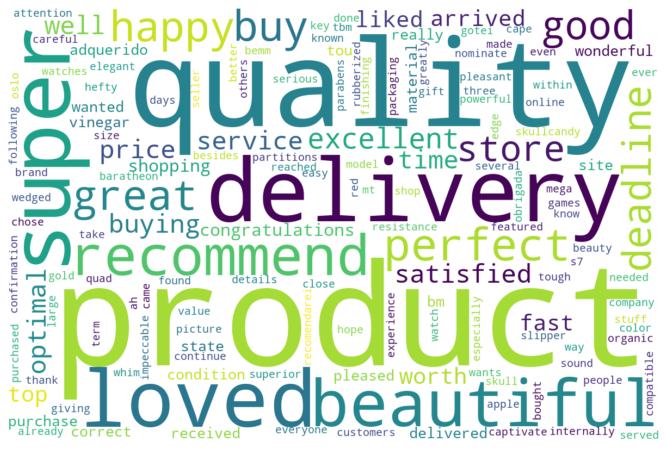

In [110]:
text = ""

tmp = eng_reviews[eng_reviews.product_id.isin(review_sentiments.index[:20])]
tmp.review_eng.apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= STOP_WORDS_ENG,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')

The wordcloud shows the most frequent words as bold. In the top 20 products with positive reviews, words such as - good, beautiful, super, loved, recommend, perfect, satisfied are used mostly. Hence the positive sentiment assigned.

In [111]:
review_sentiments[-20:]

,score,sentiment
product_id,,
77e8ff91e2cccad62b30a0a83bec431e,-6.0,negative
0cf3ab3383c2ae6f5750e5847c749e22,-6.0,negative
24c855c83d506d85c7386ff94d6c8db1,-6.0,negative
9e88896ff9b39f42a9652dc0730ecabc,-6.0,negative
1a0ef485e35802dd1d23ab5446cac458,-6.0,negative
093cd981b714bcdff182b427d87fc8fc,-6.0,negative
07797d4315ce5c1570e0a484472e04b5,-6.0,negative
ea768069ca084e95a752ee7d51a8ff70,-6.0,negative
d5abd3b28e2a7a0da8f0a4617f9188d6,-6.0,negative


The least popular 20 products according to the reviews are listed above.

(-0.5, 1199.5, 799.5, -0.5)

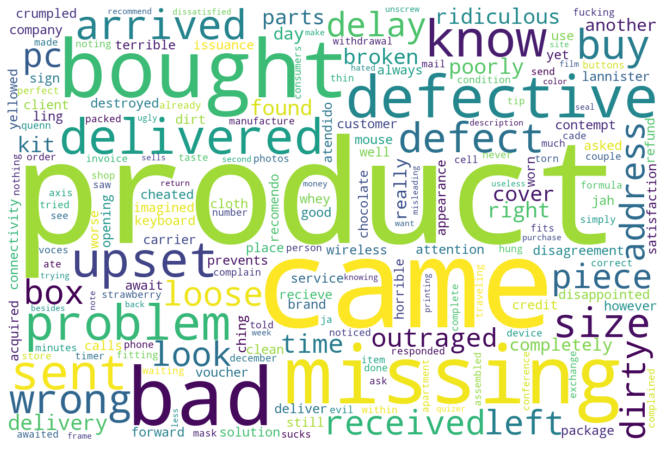

In [113]:
text = ""

tmp = eng_reviews[eng_reviews.product_id.isin(review_sentiments.index[-20:])]
tmp.review_eng.apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= STOP_WORDS_ENG,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')

The wordcloud for least popular 20 products shows why these product's overall sentiment score is negative. The most frequent words are - bad, missing, upset, problem, defective etc.

Using Textblob model now,

In [117]:
scores = eng_reviews.review_eng.apply(
    lambda text: round(TextBlob(text).sentiment.polarity, 3) 
)

sentiments = scores.apply(
    lambda s: 'positive' if s > 0 else 'negative' if s < 0 else 'neutral'
)

textblob_reviews = pd.concat([eng_reviews.product_id, score_afinn, sentiment_afinn], axis=1)
textblob_reviews.columns= ['product_id', 'score', 'sentiment']
textblob_reviews.sample(5)

,product_id,score,sentiment
16414,2501eb540473502ef149a3a848b2f8f0,3.0,positive
1069,c354569eefd558bf201d0aedf35608ed,-1.0,negative
27358,fb783e3e545937820b57fe539b2c5a6c,7.0,positive
16931,404a57563d487aecbc2b1a01d9b89aab,-1.0,negative
16825,52f7bc73b7afc86c2b4a318c19671e2e,2.0,positive


The predictions are again grouped on product_id and aggregated on score and sentiment as before.

In [122]:
review_sentiments = textblob_reviews.groupby('product_id').agg({
    'score':'mean',
    'sentiment':pd.Series.mode
})

review_sentiments = review_sentiments.sort_values('score',ascending= False)
review_sentiments[:20]

,score,sentiment
product_id,,
37664a6100bf523c545b7040be69ad00,17.0,positive
f71954485428cf87945953ea0a0a6229,16.0,positive
f82a4b08cf7b2bf375fb77e519231f9a,16.0,positive
c696cd2db7870be08c37822f7c0ef831,15.0,positive
92857a2b590adeae8d5992511dc197e9,15.0,positive
1574ed2c73e4465c572f68dd77528203,14.0,positive
12e479f1c2c0417147a3e36302485e30,14.0,positive
4563095e06df1fa67de2eade86f4f01b,14.0,positive
0c96091f6f20b1d2c946a933370782a4,14.0,positive


The above are the top 20 products having popular sentiments.<br>
The word clouds would almost show the same thing and hence are not repeated again.<br>


In [126]:
review_sentiments[-20:]

,score,sentiment
product_id,,
77e8ff91e2cccad62b30a0a83bec431e,-6.0,negative
0cf3ab3383c2ae6f5750e5847c749e22,-6.0,negative
24c855c83d506d85c7386ff94d6c8db1,-6.0,negative
9e88896ff9b39f42a9652dc0730ecabc,-6.0,negative
1a0ef485e35802dd1d23ab5446cac458,-6.0,negative
093cd981b714bcdff182b427d87fc8fc,-6.0,negative
07797d4315ce5c1570e0a484472e04b5,-6.0,negative
ea768069ca084e95a752ee7d51a8ff70,-6.0,negative
d5abd3b28e2a7a0da8f0a4617f9188d6,-6.0,negative


 The bottom 20, least popular products based on review scores are listed above.


Since these methods were unsupervised, there are no target values to check the predictions against. But there can be a comparision made between the two models, by assuming one model to predict actual values and the other model be tested agaisnt it. This way it can be said how many predictions match between the two. If most of the  predictions between the two match, then that can be said as the true value for that review.

In [130]:
print(confusion_matrix(afinn_reviews.sentiment, textblob_reviews.sentiment, labels= ['positive','neutral','negative']))

[[5547    0    0]
 [   0 3212    0]
 [   0    0 1350]]


The confusion matrix shows that between the two models, the predictions match and hence are considered to be true labels for the reviews. Now that the sentiments with score for each review is knows, products with positive sentiments can be viewed to find what was it that customers liked. Similarly negative sentiment reviews can be analyzed to understand what customers disliked and how that can be improved. Based on wordcloud it was clear that defective, missing or delay are words mostly in negative sentiment reviews and are the causes for it.

The next part of the analysis, is to make a supervised learning model for the reviews. As compared to the previous method, unsupervised learning model is trained on the reviews and tested against a target variable. This ensures that the model is a perfect fit. Further, the model can be used to classify future reviews as they are posted.

For the model, the target has to be created. Each review has a rating assigned. Let us consider a benchmark - 2.5
Any rating below 2.5 is conidered as negative and above 2.5 as positive.

In [154]:
df.dropna(subset= ['review_comment_message'], inplace= True)

df['target'] = df.review_score.apply(lambda s: 1 if int(s) > 2.5 else 0)
reviews = df[['review_score','review_comment_message','target']]
reviews.head(5)

,review_score,review_comment_message,target
0,5,Super adooorei o delineador ele é bem preto e ...,1
1,5,Excelente apontador! Em 3 segundos uma ponta p...,1
3,1,modelo comprado: travesseiro memoria carinho B...,0
6,2,Veio faltando o bebê conforto,0
9,1,A compra foi de cinco almofadas marron. Só vie...,0


The next step is to clean all the reviews. Preprocessing is done as:-
* Lower case
* Remove punctuations
* Remove stop words

For this model, the reviews have not been translated.

In [155]:
def preprocessing(text):
    text = re.sub('[\W]+',' ',text)
    text = text.lower()
    words= word_tokenize(text)
    return " ".join([word for word in words if word not in STOP_WORDS])

reviews.review_comment_message = reviews.review_comment_message.apply(preprocessing)
reviews

/home/raj/anaconda3/envs/r_env/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,review_score,review_comment_message,target
0,5,super adooorei delineador bem preto smp usei m...,1
1,5,excelente apontador 3 segundos ponta perfeita,1
3,1,modelo comprado travesseiro memoria carinho ba...,0
6,2,veio faltando bebê conforto,0
9,1,compra cinco almofadas marron vieram duas core...,0
...,...,...,...
104661,5,produto ótima qualidade fiquei super feliz agi...,1
104663,5,boa loja parabéns,1
104665,4,recomendo produto pois super adequado problema...,1
104666,4,bom,1


The reviews are now cleaned and free of Stop words. Another important step in preprocessing is stemming the words. The reviews may have same words in different tense. By the model, these are picked up as different words for example - doing, does, done are all of the same root/stem do, but wont be treated as such.

A stemmer is applied to each word in the review.

In [160]:
def stem_text(text):
    stemmer = RSLPStemmer()
    words = word_tokenize(text)
    return " ".join([stemmer.stem(word) for word in words])

reviews.review_comment_message = reviews.review_comment_message.apply(stem_text)
reviews.head(5)

/home/raj/anaconda3/envs/r_env/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,review_score,review_comment_message,target
0,5,sup adooor deline bem pret smp use mac seri be...,1
1,5,excel apont 3 segund pont perfeit,1
3,1,model compr travess memor car baby pillow mode...,0
6,2,vei falt bebê confort,0
9,1,compr cinc almof marron vier dua cor difer mar...,0


For sentiment analysis, it is important to understand how the reviews can be. A text can either be objective or subjective. Objective text usually inform a fact whereas subjective text show emotions. Emotions is what the sentiment analysis banks on. It is important to understand which words can show emotion and how crucial can the words be for the same. Say a word "product" in the reviews will be very common, and such words do not usually show emotions nor due to their frequency account for classification. A word which is rare in the reviews can really be crucial in identifying the sentiment of the review.<br>

Hence tfidf metric is chosen to give weightage to each word in the review. A very frequent word is given less weightage, whereas a rare word is given a heavy weightage. After applying the weighting, data is split into train and test.

In [169]:
tfidf = TfidfVectorizer(use_idf= True, norm= 'l2', smooth_idf= True)

y = reviews.target
X = tfidf.fit_transform(reviews.review_comment_message)

Before splitting we check the distribution of the target variable. This can give a good idea of the splitting ratio for train and test.

In [168]:
reviews.target.value_counts(normalize= True)

1    0.719562
0    0.280438
Name: target, dtype: float64

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.280438,
    random_state= 3,
    shuffle= False
)

Now the train and test data are ready, the model is fit on the training data and tested on test data.<br>

The model to try is the Logistic Regression. LogisticRegressionCV performs K-fold cross validation and grid search for C and l1-ratio values.

In [183]:
lr_mod = LogisticRegressionCV(
    cv= 5,
    scoring= 'accuracy',
    n_jobs= -1,
    max_iter= 400,
    verbose= 3,
    random_state= 1
)

lr_mod.fit(X_train, y_train)
pred = lr_mod.predict(X_test)
print(classification_report(pred,y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3436
           1       0.92      0.92      0.92      8896

    accuracy                           0.89     12332
   macro avg       0.86      0.86      0.86     12332
weighted avg       0.89      0.89      0.89     12332



The logistic Regression model, after cross validation gave an accuracy of 89%. The weighted average for precision, recall and f1-score are also at 89%. But it can be seen that precision and recall for negative class is way lower than positive class, this is because of the imbalance in the dataset.<br>

The next model to be tested is the RandomForest Classifier. The RandomForest Classifier is an ensemble technique and powerful in removing biases and errors using weak learners.

In [181]:
rf_mod = RandomForestClassifier(
    n_estimators= 300,
    n_jobs= -1,
    verbose= 1
)

rf_mod.fit(X_train, y_train)
pred = rf_mod.predict(X_test)
print(classification_report(pred,y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s


              precision    recall  f1-score   support

           0       0.81      0.80      0.80      3499
           1       0.92      0.93      0.92      8814

    accuracy                           0.89     12313
   macro avg       0.87      0.86      0.86     12313
weighted avg       0.89      0.89      0.89     12313



[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.9s finished


The RandomForest Classifier shows improved results in terms of precision and recall of negative class as compared to Logistic Regression, yet there is a gap between positive and negative class. The accuracy and weighted average of precision, recall and f1-score are all 89%.<br>

The next model to be tested is the SupportVector Machine.

In [179]:
sv_mod = SVC(
    probability= True,
    random_state= 1,
    verbose= 1
)

sv_mod.fit(X_train, y_train)
pred = sv_mod.predict(X_test)
print(classification_report(pred, y_test))

[LibSVM]              precision    recall  f1-score   support

           0       0.82      0.81      0.82      3476
           1       0.93      0.93      0.93      8837

    accuracy                           0.90     12313
   macro avg       0.87      0.87      0.87     12313
weighted avg       0.90      0.90      0.90     12313



The SupportVector Machine shows improved accuracy and weighted average of precision, recall and f1-score of 90%. The gap between positive and negative classes still exists.<br>

For model selection, ROC curve and AUC score is reported. The model with higher AUC is the model to be selected.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.9s finished


AUC LogisticRegression:  0.942435674180289
AUC RandomForest:  0.9450056715387773
AUC SupportVector:  0.9485774753873948


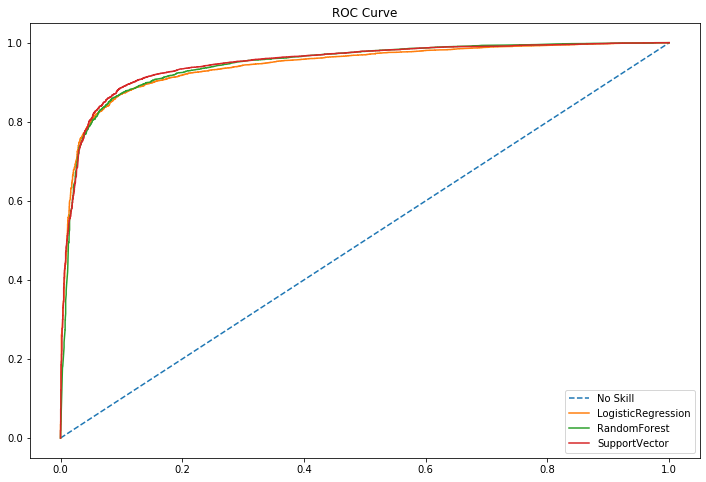

In [192]:
noskill_prob = [0 for _ in range(len(y_test))]

lr_prob = lr_mod.predict_proba(X_test)[:,1]
rf_prob = rf_mod.predict_proba(X_test)[:,1]
sv_prob = sv_mod.predict_proba(X_test)[:,1]

auc_lr = roc_auc_score(y_test, lr_prob)
auc_rf = roc_auc_score(y_test, rf_prob)
auc_sv = roc_auc_score(y_test, sv_prob)

print("AUC LogisticRegression: ",auc_lr)
print("AUC RandomForest: ",auc_rf)
print("AUC SupportVector: ",auc_sv)

ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_prob)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
sv_fpr, sv_tpr, _ = roc_curve(y_test, sv_prob)

plt.figure(figsize= (12,8))
plt.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'No Skill')
plt.plot(lr_fpr, lr_tpr, linestyle= '-', label= 'LogisticRegression')
plt.plot(rf_fpr, rf_tpr, linestyle= '-', label= 'RandomForest')
plt.plot(sv_fpr, sv_tpr, linestyle= '-', label= 'SupportVector')
plt.title("ROC Curve")
plt.legend(loc= 'lower right')
plt.show()

All the three models have very close AUC scores. Support Vector machine has the highest of them all. The SupportVector model has shown highest AUC and accuracy among all the models. Thus the SupportVector model is chosen as the final model. The trained model can further be used to classify new reviews posted as orders are placed.<br>

It is important to analyze the shortcomings of the model, this can give insights and feedback for the feature selection process. For the sentiment analysis, the reviews that were misclassified are analyzed. The aim is to find out why these reviews were misclassified by the model.

In [194]:
reviews['prediction'] = sv_mod.predict(X)

<ipython-input-194-0431d78b8c99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['prediction'] = sv_mod.predict(X)


Those reviews that were misclassified as negative, but were positive (False negatives) are analyzed first.

(-0.5, 1199.5, 799.5, -0.5)

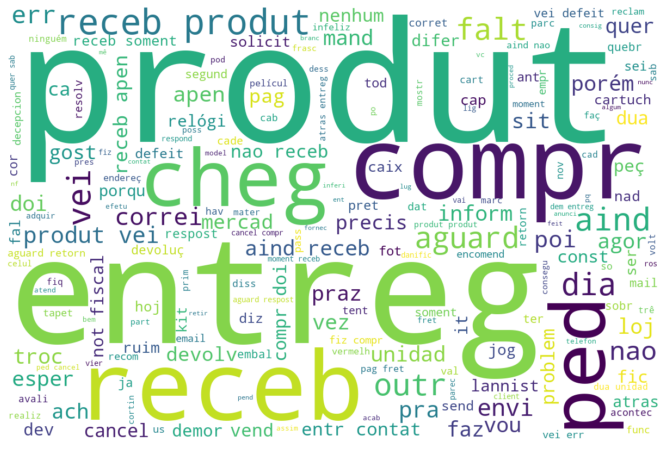

In [204]:
tmp = reviews[(reviews.target == 1) & (reviews.prediction == 0)]
text = ""
tmp.review_comment_message.apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= STOP_WORDS,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")

The word cloud shows that the reviews that were misclassified as negative even though they were positive were - entreg (delivery), ped (request), receb (reveive), compr (purchase), aguard (wait), produto (product), cheg (arrived) etc. These words do not really show any emotions and maybe were misclassified as these reviews didnot have enough subjective words to classify on.<br>

Now to analyze those reviews that were negative but were classified as positive, (False positives).

(-0.5, 1199.5, 799.5, -0.5)

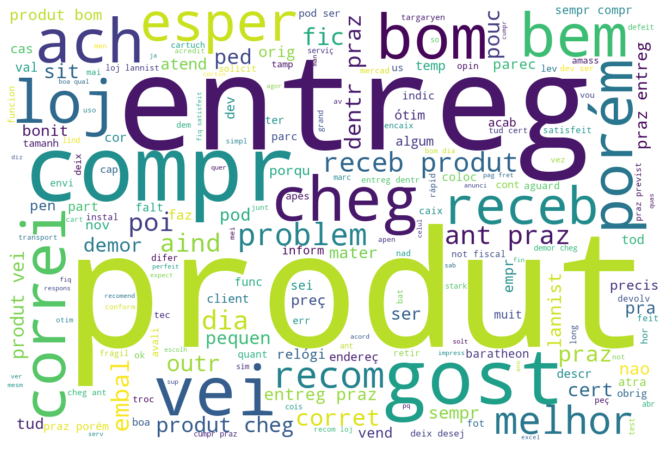

In [206]:
tmp = reviews[(reviews.target == 0) & (reviews.prediction == 1)]
text = ""
tmp.review_comment_message.apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= STOP_WORDS,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")

A few words are same as the previous case such as produto (product), entreg (delivery), comprar (purchase), cheg (arrived) etc. There are a few words here that actually show positive emotions - bom (good), gost (like), melhor (best), praz (pleasureable) etc. These words are actually positive in negative reviews and thus are classified that way.

Based on the analysis, there are no manipulations that can be done. In the case of False negatives, the reviews contained many objective words and hence they were misclassified. For False positives, the reviews actually contained postive words, the target may have been flawed, So the model was actually predicting correctly.<br>

Hence the final model is SupportVector Machine for the sentiment analysis.